# Predict traffic with XGBoost

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv(
    "data/fr.wikipedia.org_20190220-20230221_pageviews.csv",
)
df = df.rename({
    "Date":"date",
    "fr.wikipedia.org":"pageviews",
},axis=1)
df = df.set_index("date")
# convert date to datetime
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
df.head()

pageviews
date                 
2019-02-20   24204230
2019-02-21   23372675
2019-02-22   22845651
2019-02-23   21805707
2019-02-24   24478639

<Axes: xlabel='date'>

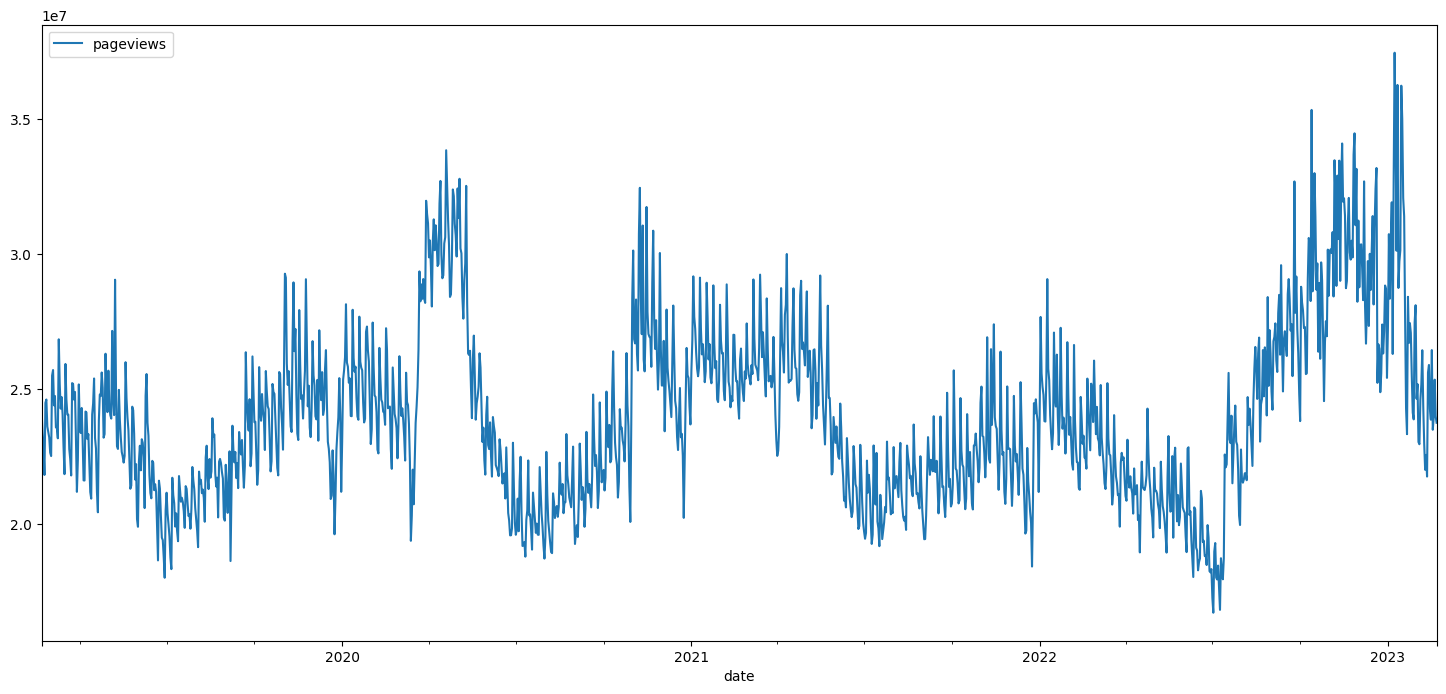

In [3]:
df.plot(figsize=[18,8])

<Axes: ylabel='Frequency'>

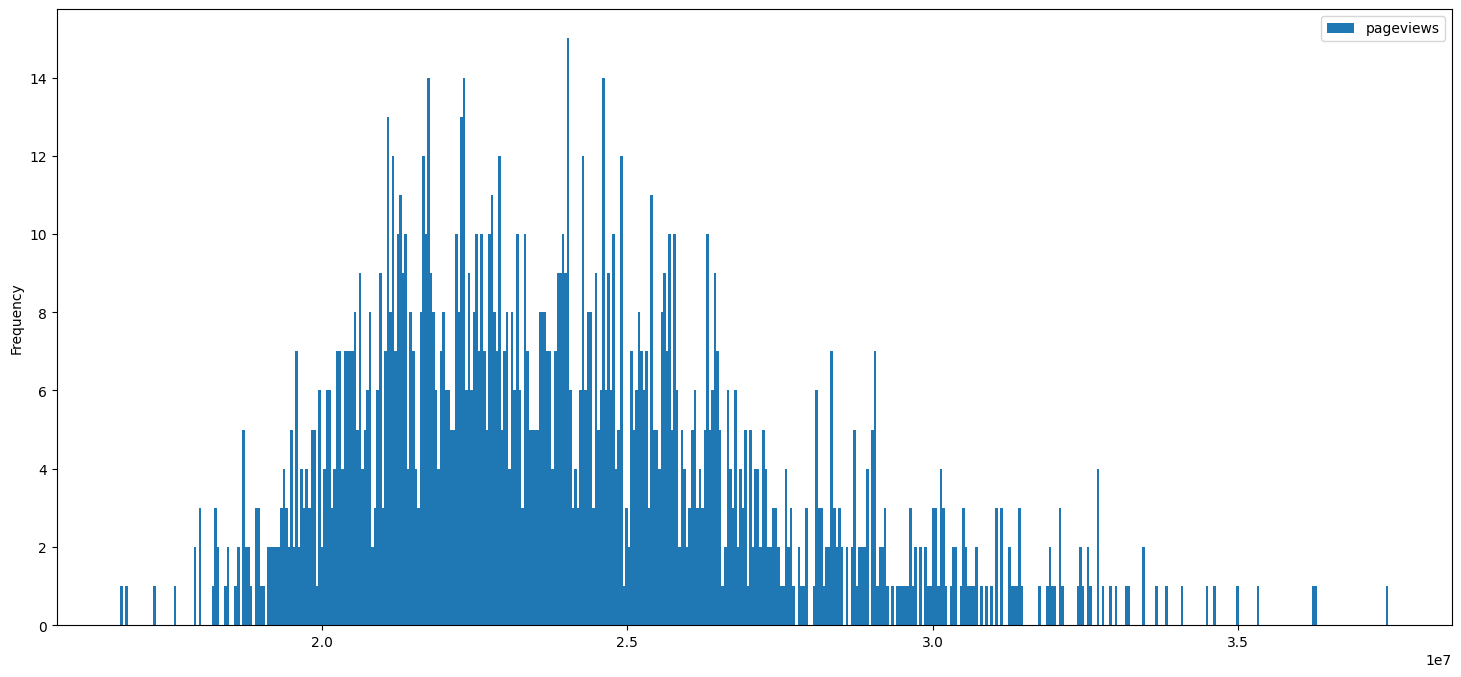

In [6]:
df.plot(kind="hist", bins=500, figsize=[18,8])

In [7]:
df[df["pageviews"] > 35000000]

pageviews
date                 
2022-10-13   35341370
2023-01-08   37462345
2023-01-11   36267757
2023-01-15   36239048
2023-01-16   35005302

In [8]:
df[(df.index > "2022-10-10") & (df.index <= "2022-10-17")]

pageviews
date                 
2022-10-11   30379419
2022-10-12   28254888
2022-10-13   35341370
2022-10-14   28614387
2022-10-15   29430480
2022-10-16   32996537
2022-10-17   31376693

## Features

In [20]:
def set_features(df):
    df = df.copy()
    df["dayofweek"] = df.index.dayofweek
    df["dayofmonth"] = df.index.day
    df["dayofyear"] = df.index.dayofyear
    df["weekofyear"] = df.index.isocalendar().week
    df["weekofyear"] = df["weekofyear"].astype(int)
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["year"] = df.index.year
    return df

df = set_features(df)
df

pageviews  dayofweek  dayofmonth  dayofyear  weekofyear  month  \
date                                                                         
2019-02-20   24204230          2          20         51           8      2   
2019-02-21   23372675          3          21         52           8      2   
2019-02-22   22845651          4          22         53           8      2   
2019-02-23   21805707          5          23         54           8      2   
2019-02-24   24478639          6          24         55           8      2   
...               ...        ...         ...        ...         ...    ...   
2023-02-17   23482278          4          17         48           7      2   
2023-02-18   23941178          5          18         49           7      2   
2023-02-19   25339082          6          19         50           7      2   
2023-02-20   23987905          0          20         51           8      2   
2023-02-21   23740242          1          21         52           8      2   

            quarter  year  is_holiday_zoneA  is_holiday_zoneB  \
date                                                            
2019-02-20        1  2019              True              True   
2019-02-21        1  2019              True              True   
2019-02-22        1  2019              True              True   
2019-02-23        1  2019              True              True   
2019-02-24        1  2019              True              True   
...             ...   ...               ...               ...   
2023-02-17        1  2023              True              True   
2023-02-18        1  2023              True              True   
2023-02-19        1  2023              True              True   
2023-02-20        1  2023             False              True   
2023-02-21        1  2023             False              True   

            is_holiday_zoneC  is_bank_holiday  
date                                           
2019-02-20             False            False  
2019-02-21             False            False  
2019-02-22             False            False  
2019-02-23              True            False  
2019-02-24              True            False  
...                      ...              ...  
2023-02-17             False            False  
2023-02-18              True            False  
2023-02-19              True            False  
2023-02-20              True            False  
2023-02-21              True            False  

[1463 rows x 12 columns]

In [11]:
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france import JoursFeries
from datetime import date

def set_holidays(df):
    d = SchoolHolidayDates()
    df = df.copy()
    df = df.reset_index()
    df["is_holiday_zoneA"] = df.date.apply(
        lambda x: d.is_holiday_for_zone(date.fromisoformat(x.strftime("%Y-%m-%d")), "A"))
    df["is_holiday_zoneB"] = df.date.apply(
        lambda x: d.is_holiday_for_zone(date.fromisoformat(x.strftime("%Y-%m-%d")), "B"))
    df["is_holiday_zoneC"] = df.date.apply(
        lambda x: d.is_holiday_for_zone(date.fromisoformat(x.strftime("%Y-%m-%d")), "C"))
    df["is_bank_holiday"] = df.date.apply(
        lambda x: JoursFeries.is_bank_holiday(date.fromisoformat(x.strftime("%Y-%m-%d")), zone="Métropole"))
    df = df.set_index("date")
    return df
df = set_holidays(df)
df

pageviews  dayofweek  dayofmonth  dayofyear  weekofyear  month  \
date                                                                         
2019-02-20   24204230          2          20         51           8      2   
2019-02-21   23372675          3          21         52           8      2   
2019-02-22   22845651          4          22         53           8      2   
2019-02-23   21805707          5          23         54           8      2   
2019-02-24   24478639          6          24         55           8      2   
...               ...        ...         ...        ...         ...    ...   
2023-02-17   23482278          4          17         48           7      2   
2023-02-18   23941178          5          18         49           7      2   
2023-02-19   25339082          6          19         50           7      2   
2023-02-20   23987905          0          20         51           8      2   
2023-02-21   23740242          1          21         52           8      2   

            quarter  year  is_holiday_zoneA  is_holiday_zoneB  \
date                                                            
2019-02-20        1  2019              True              True   
2019-02-21        1  2019              True              True   
2019-02-22        1  2019              True              True   
2019-02-23        1  2019              True              True   
2019-02-24        1  2019              True              True   
...             ...   ...               ...               ...   
2023-02-17        1  2023              True              True   
2023-02-18        1  2023              True              True   
2023-02-19        1  2023              True              True   
2023-02-20        1  2023             False              True   
2023-02-21        1  2023             False              True   

            is_holiday_zoneC  is_bank_holiday  
date                                           
2019-02-20             False            False  
2019-02-21             False            False  
2019-02-22             False            False  
2019-02-23              True            False  
2019-02-24              True            False  
...                      ...              ...  
2023-02-17             False            False  
2023-02-18              True            False  
2023-02-19              True            False  
2023-02-20              True            False  
2023-02-21              True            False  

[1463 rows x 12 columns]

## Train / Test

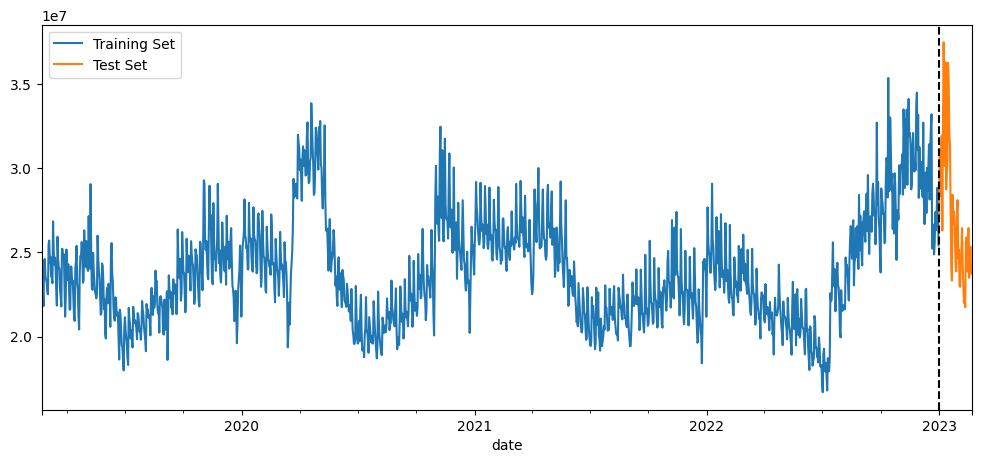

In [21]:
train = df[df.index < "2023-01-01"]
test = df[df.index >= "2023-01-01"]

fig, ax = plt.subplots(figsize=(12,5))
train["pageviews"].plot(ax=ax, label="Training Set")
test["pageviews"].plot(ax=ax, label="Test Set")
ax.axvline(pd.to_datetime("2023-01-01"), color="black", ls="--")
ax.legend(["Training Set","Test Set"])
plt.show()

In [14]:
train.columns

Index(['pageviews', 'dayofweek', 'dayofmonth', 'dayofyear', 'weekofyear',
       'month', 'quarter', 'year', 'is_holiday_zoneA', 'is_holiday_zoneB',
       'is_holiday_zoneC', 'is_bank_holiday'],
      dtype='object')

In [15]:
FEATURES = ['dayofweek', 'dayofmonth', 'dayofyear', 'weekofyear', \
       'month', 'quarter', 'year', 'is_holiday_zoneA', 'is_holiday_zoneB', \
       'is_holiday_zoneC', 'is_bank_holiday']
TARGET = "pageviews"

In [22]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [24]:
reg = xgb.XGBRegressor(
    base_score = 0.5,
    booster = 'gbtree',
    n_estimators = 2000,
    early_stopping_rounds = 50,
    objective = 'reg:linear',
    max_depth = 5,
    learning_rate = 0.01,
)
reg.fit(
    X_train,
    y_train,
    eval_set = [(X_train, y_train), (X_test, y_test)],
    verbose = 100,
)

[17:36:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:23856736.56743	validation_1-rmse:27285877.67092
[100]	validation_0-rmse:8970118.55710	validation_1-rmse:13001875.50613
[200]	validation_0-rmse:3626245.37786	validation_1-rmse:7828041.71604
[300]	validation_0-rmse:1822876.86298	validation_1-rmse:5873727.25389
[400]	validation_0-rmse:1244757.60501	validation_1-rmse:5087730.01983
[500]	validation_0-rmse:986633.30181	validation_1-rmse:4761387.98224
[600]	validation_0-rmse:906889.51927	validation_1-rmse:4627008.82576
[700]	validation_0-rmse:838634.59540	validation_1-rmse:4562444.56392
[800]	validation_0-rmse:785653.28769	validation_1-rmse:4520843.69274
[900]	validation_0-rmse:750816.54221	validation_1-rmse:4495827.44347
[1000]	validation_0-rmse:712967.72888	validation_1-rmse:4473189.21084
[1100]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [27]:
test["prediction"] = reg.predict(X_test)
test[["pageviews","prediction"]]

/var/folders/44/qy6r1ftj6md01k6x8thf6pxc0000gn/T/ipykernel_38686/1077380920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = reg.predict(X_test)


pageviews  prediction
date                             
2023-01-01   27272033  26140550.0
2023-01-02   30733666  24867252.0
2023-01-03   28343296  24968300.0
2023-01-04   30558462  24971432.0
2023-01-05   31915879  24141448.0
2023-01-06   26292220  23675464.0
2023-01-07   32700550  24903454.0
2023-01-08   37462345  28492532.0
2023-01-09   34614748  25532514.0
2023-01-10   30119186  24874452.0
2023-01-11   36267757  24827360.0
2023-01-12   28739130  23517390.0
2023-01-13   29727878  23096762.0
2023-01-14   30138762  23453068.0
2023-01-15   36239048  27103272.0
2023-01-16   35005302  25241508.0
2023-01-17   32075116  24497612.0
2023-01-18   31402259  24596832.0
2023-01-19   27596610  23899960.0
2023-01-20   24269272  23254564.0
2023-01-21   23318281  23592152.0
2023-01-22   28410899  27328014.0
2023-01-23   26699977  24894026.0
2023-01-24   27435939  24010656.0
2023-01-25   27068305  23877202.0
2023-01-26   25457228  23289208.0
2023-01-27   24114728  22789822.0
2023-01-28   23866897  23186652.0
2023-01-29   27464952  26989344.0
2023-01-30   28099626  25022196.0
2023-01-31   24632907  23932622.0
2023-02-01   25174509  23319716.0
2023-02-02   23027417  23074902.0
2023-02-03   22944372  22505118.0
2023-02-04   24597147  22841618.0
2023-02-05   25157533  26607180.0
2023-02-06   26430115  24526684.0
2023-02-07   24359955  23472352.0
2023-02-08   22970277  23373962.0
2023-02-09   21997443  22627840.0
2023-02-10   22548965  22178922.0
2023-02-11   21746574  21780430.0
2023-02-12   25607770  24619068.0
2023-02-13   25884446  23450536.0
2023-02-14   24255256  22992446.0
2023-02-15   23855176  22802432.0
2023-02-16   26436289  22439856.0
2023-02-17   23482278  22252786.0
2023-02-18   23941178  22199748.0
2023-02-19   25339082  25054478.0
2023-02-20   23987905  23981180.0
2023-02-21   23740242  23021298.0

In [28]:
df = df.merge(test[["prediction"]], how="left", left_index=True, right_index=True)
df

pageviews  dayofweek  dayofmonth  dayofyear  weekofyear  month  \
date                                                                         
2019-02-20   24204230          2          20         51           8      2   
2019-02-21   23372675          3          21         52           8      2   
2019-02-22   22845651          4          22         53           8      2   
2019-02-23   21805707          5          23         54           8      2   
2019-02-24   24478639          6          24         55           8      2   
...               ...        ...         ...        ...         ...    ...   
2023-02-17   23482278          4          17         48           7      2   
2023-02-18   23941178          5          18         49           7      2   
2023-02-19   25339082          6          19         50           7      2   
2023-02-20   23987905          0          20         51           8      2   
2023-02-21   23740242          1          21         52           8      2   

            quarter  year  is_holiday_zoneA  is_holiday_zoneB  \
date                                                            
2019-02-20        1  2019              True              True   
2019-02-21        1  2019              True              True   
2019-02-22        1  2019              True              True   
2019-02-23        1  2019              True              True   
2019-02-24        1  2019              True              True   
...             ...   ...               ...               ...   
2023-02-17        1  2023              True              True   
2023-02-18        1  2023              True              True   
2023-02-19        1  2023              True              True   
2023-02-20        1  2023             False              True   
2023-02-21        1  2023             False              True   

            is_holiday_zoneC  is_bank_holiday  prediction  
date                                                       
2019-02-20             False            False         NaN  
2019-02-21             False            False         NaN  
2019-02-22             False            False         NaN  
2019-02-23              True            False         NaN  
2019-02-24              True            False         NaN  
...                      ...              ...         ...  
2023-02-17             False            False  22252786.0  
2023-02-18              True            False  22199748.0  
2023-02-19              True            False  25054478.0  
2023-02-20              True            False  23981180.0  
2023-02-21              True            False  23021298.0  

[1463 rows x 13 columns]

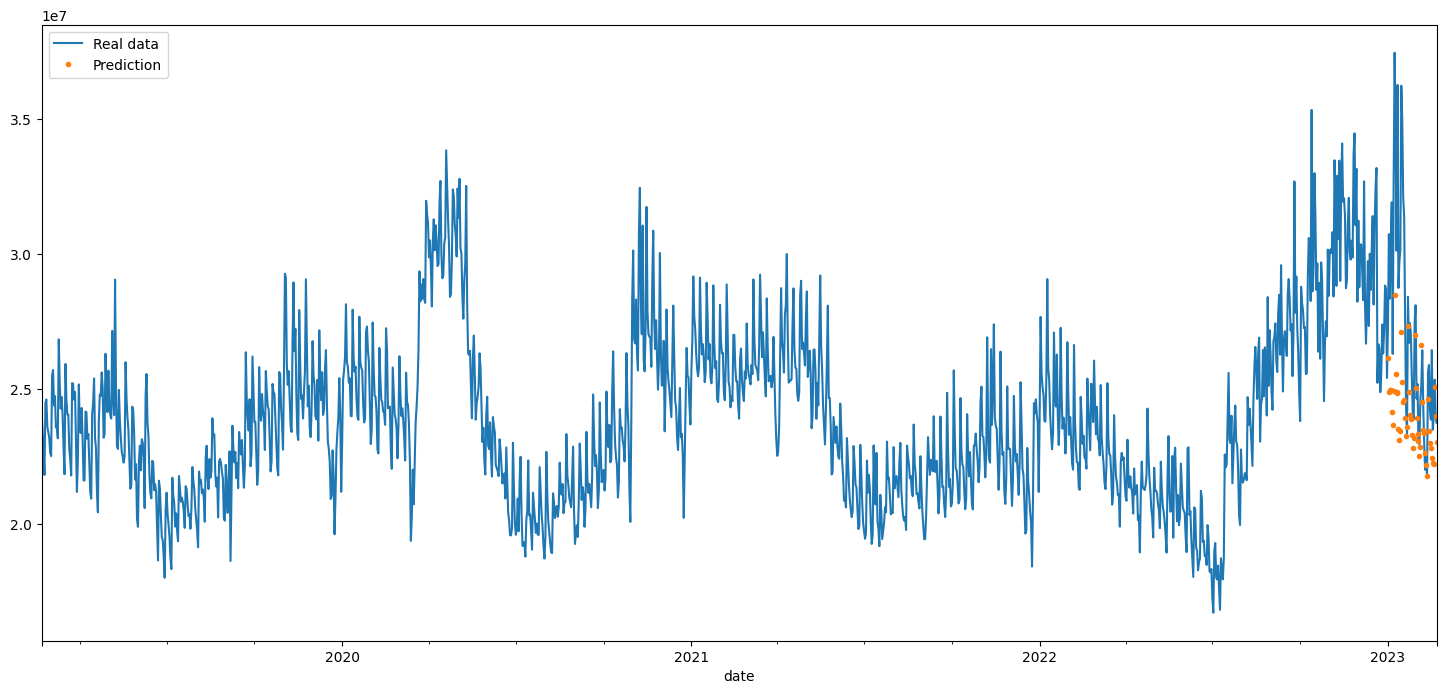

In [32]:
ax = df[["pageviews"]].plot(figsize=[18,8])
df["prediction"].plot(ax=ax, style=".")
plt.legend(["Real data", "Prediction"])

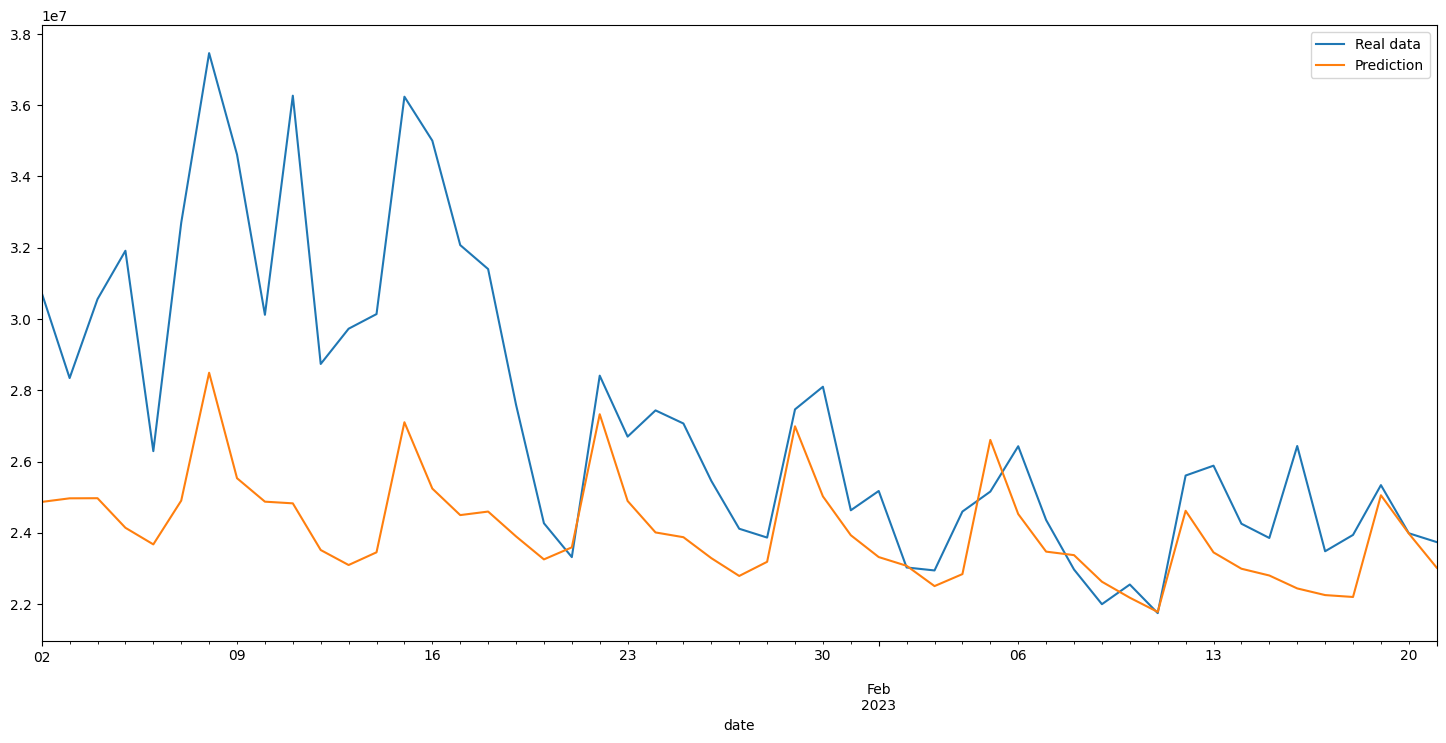

In [34]:
ax = df[df.index > "2023-01-01"][["pageviews"]].plot(figsize=[18,8])
df[df.index > "2023-01-01"]["prediction"].plot(ax=ax)
plt.legend(["Real data", "Prediction"])

In [38]:
fi = pd.DataFrame(
    data = reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["importance"],
)
fi.sort_values(by="importance",ascending=False)

importance
year                0.248523
dayofyear           0.203009
weekofyear          0.169018
dayofweek           0.105955
is_bank_holiday     0.090490
is_holiday_zoneB    0.089432
month               0.031023
is_holiday_zoneA    0.021974
is_holiday_zoneC    0.021096
dayofmonth          0.019480
quarter             0.000000

## Predict the future

In [40]:
future = pd.DataFrame(index=pd.date_range('2023-02-22', '2023-03-15', freq='1d'))
future.index = future.index.rename("date")
future

Empty DataFrame
Columns: []
Index: [2023-02-22 00:00:00, 2023-02-23 00:00:00, 2023-02-24 00:00:00, 2023-02-25 00:00:00, 2023-02-26 00:00:00, 2023-02-27 00:00:00, 2023-02-28 00:00:00, 2023-03-01 00:00:00, 2023-03-02 00:00:00, 2023-03-03 00:00:00, 2023-03-04 00:00:00, 2023-03-05 00:00:00, 2023-03-06 00:00:00, 2023-03-07 00:00:00, 2023-03-08 00:00:00, 2023-03-09 00:00:00, 2023-03-10 00:00:00, 2023-03-11 00:00:00, 2023-03-12 00:00:00, 2023-03-13 00:00:00, 2023-03-14 00:00:00, 2023-03-15 00:00:00]

In [41]:
future = set_features(future)
future = set_holidays(future)
future

dayofweek  dayofmonth  dayofyear  weekofyear  month  quarter  \
date                                                                       
2023-02-22          2          22         53           8      2        1   
2023-02-23          3          23         54           8      2        1   
2023-02-24          4          24         55           8      2        1   
2023-02-25          5          25         56           8      2        1   
2023-02-26          6          26         57           8      2        1   
2023-02-27          0          27         58           9      2        1   
2023-02-28          1          28         59           9      2        1   
2023-03-01          2           1         60           9      3        1   
2023-03-02          3           2         61           9      3        1   
2023-03-03          4           3         62           9      3        1   
2023-03-04          5           4         63           9      3        1   
2023-03-05          6           5         64           9      3        1   
2023-03-06          0           6         65          10      3        1   
2023-03-07          1           7         66          10      3        1   
2023-03-08          2           8         67          10      3        1   
2023-03-09          3           9         68          10      3        1   
2023-03-10          4          10         69          10      3        1   
2023-03-11          5          11         70          10      3        1   
2023-03-12          6          12         71          10      3        1   
2023-03-13          0          13         72          11      3        1   
2023-03-14          1          14         73          11      3        1   
2023-03-15          2          15         74          11      3        1   

            year  is_holiday_zoneA  is_holiday_zoneB  is_holiday_zoneC  \
date                                                                     
2023-02-22  2023             False              True              True   
2023-02-23  2023             False              True              True   
2023-02-24  2023             False              True              True   
2023-02-25  2023             False              True              True   
2023-02-26  2023             False              True              True   
2023-02-27  2023             False             False              True   
2023-02-28  2023             False             False              True   
2023-03-01  2023             False             False              True   
2023-03-02  2023             False             False              True   
2023-03-03  2023             False             False              True   
2023-03-04  2023             False             False              True   
2023-03-05  2023             False             False              True   
2023-03-06  2023             False             False             False   
2023-03-07  2023             False             False             False   
2023-03-08  2023             False             False             False   
2023-03-09  2023             False             False             False   
2023-03-10  2023             False             False             False   
2023-03-11  2023             False             False             False   
2023-03-12  2023             False             False             False   
2023-03-13  2023             False             False             False   
2023-03-14  2023             False             False             False   
2023-03-15  2023             False             False             False   

            is_bank_holiday  
date                         
2023-02-22            False  
2023-02-23            False  
2023-02-24            False  
2023-02-25            False  
2023-02-26            False  
2023-02-27            False  
2023-02-28            False  
2023-03-01            False  
2023-03-02            False  
2023-03-03            False  
2023-03-04            False  
2023-03-05          

In [42]:
future["prediction"] = reg.predict(future[FEATURES])
future

dayofweek  dayofmonth  dayofyear  weekofyear  month  quarter  \
date                                                                       
2023-02-22          2          22         53           8      2        1   
2023-02-23          3          23         54           8      2        1   
2023-02-24          4          24         55           8      2        1   
2023-02-25          5          25         56           8      2        1   
2023-02-26          6          26         57           8      2        1   
2023-02-27          0          27         58           9      2        1   
2023-02-28          1          28         59           9      2        1   
2023-03-01          2           1         60           9      3        1   
2023-03-02          3           2         61           9      3        1   
2023-03-03          4           3         62           9      3        1   
2023-03-04          5           4         63           9      3        1   
2023-03-05          6           5         64           9      3        1   
2023-03-06          0           6         65          10      3        1   
2023-03-07          1           7         66          10      3        1   
2023-03-08          2           8         67          10      3        1   
2023-03-09          3           9         68          10      3        1   
2023-03-10          4          10         69          10      3        1   
2023-03-11          5          11         70          10      3        1   
2023-03-12          6          12         71          10      3        1   
2023-03-13          0          13         72          11      3        1   
2023-03-14          1          14         73          11      3        1   
2023-03-15          2          15         74          11      3        1   

            year  is_holiday_zoneA  is_holiday_zoneB  is_holiday_zoneC  \
date                                                                     
2023-02-22  2023             False              True              True   
2023-02-23  2023             False              True              True   
2023-02-24  2023             False              True              True   
2023-02-25  2023             False              True              True   
2023-02-26  2023             False              True              True   
2023-02-27  2023             False             False              True   
2023-02-28  2023             False             False              True   
2023-03-01  2023             False             False              True   
2023-03-02  2023             False             False              True   
2023-03-03  2023             False             False              True   
2023-03-04  2023             False             False              True   
2023-03-05  2023             False             False              True   
2023-03-06  2023             False             False             False   
2023-03-07  2023             False             False             False   
2023-03-08  2023             False             False             False   
2023-03-09  2023             False             False             False   
2023-03-10  2023             False             False             False   
2023-03-11  2023             False             False             False   
2023-03-12  2023             False             False             False   
2023-03-13  2023             False             False             False   
2023-03-14  2023             False             False             False   
2023-03-15  2023             False             False             False   

            is_bank_holiday  prediction  
date                                     
2023-02-22            False  22813586.0  
2023-02-23            False  22425228.0  
2023-02-24            False  22983974.0  
2023-02-25            False  23011370.0  
2023-02-26            False  25863724.0  
2023-02-27            False  24638952.0  
2023-02-28            False  23720404.0  
2023-03-01            False  231